In [7]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict,Annotated,Literal
from dotenv import load_dotenv
from pydantic import BaseModel,Field


In [ ]:
load_dotenv()

True

In [9]:
model=ChatGoogleGenerativeAI(
    model='gemini-2.5-flash'
)

In [10]:
class sentimentSchema(BaseModel):
    sentiment:Literal['Positive','Negative']=Field(description='Sentiment of the review')

In [11]:
class DiagonosisSchema(BaseModel):
    issue_type:Literal['UI','Bug','Performance','Support','Software','others']=Field(description='The category pf the review mentioned in the sentiment')
    tone:Literal['angry','frustated','disappointed','calm']=Field(description='The emotional tone expressed by the user in the review')
    urgency:Literal['low','medium','high']=Field(description='How urgent or critical the issue appears to be')

In [12]:
final_model_1=model.with_structured_output(sentimentSchema)
final_model_2=model.with_structured_output(DiagonosisSchema)

In [13]:
class ReviewState(TypedDict):
    review:str
    sentiment:Literal['Positive',"Negative"]
    diagnosis:dict
    response:str
    

In [23]:
def find_sentiment(state:ReviewState):
    prompt=f'Find the sentiment of the following review: \n {state['review']}'
    output=final_model_1.invoke(prompt).sentiment
    return {'sentiment':output}

def checkSentiment(state:ReviewState)->Literal['Positive_response','Run_Diagnosis']:
    if state['sentiment']=='Positive':
        return 'Positive_response'
    else:
        return 'Run_Diagnosis'

def Positive_response(state:ReviewState):
    prompt=f'Genrate a thank you message for the user for giving the following review:\n {state['review']}.\n\nAlso request the user to leave a feedback in our website'
    output=model.invoke(prompt).content
    return {'response':output}

def Run_Diagnosis(state:ReviewState):
    prompt=f'Diagnose the following review;\n{state['review']}\n\n Report issue type,tone and urgency of the review'
    response=final_model_2.invoke(prompt)
    return {'diagnosis':response.model_dump()}

def Negative_response(state:ReviewState):
    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.Write an empathetic, helpful resolution message."""
    response=model.invoke(prompt).content
    return {'response':response}

In [24]:
graph=StateGraph(ReviewState)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('Positive_response',Positive_response)
graph.add_node('Negative_response',Negative_response)
graph.add_node('Run_Diagnosis',Run_Diagnosis)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',checkSentiment)

graph.add_edge('Run_Diagnosis','Negative_response')
graph.add_edge('Negative_response',END)
graph.add_edge('Positive_response',END)

workflow=graph.compile()

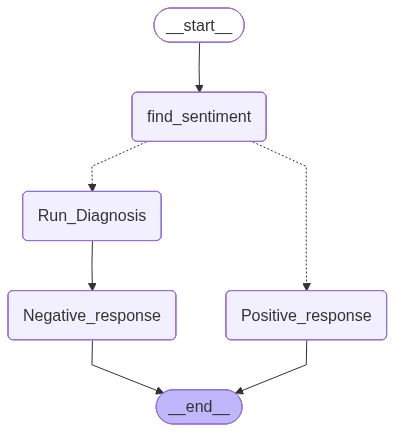

In [25]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [26]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'Negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustated', 'urgency': 'high'},
 'response': "Subject: [Your Company Name] Support - Re: Your High Urgency Bug Report - We're on it!\n\nHi [User Name],\n\nI'm so sorry to hear you're experiencing this frustrating bug, and I completely understand why you've marked it as high urgency. Thank you for reaching out and bringing this to our attention.\n\nWe know how disruptive and annoying these kinds of issues can be, especially when you're trying to get important work done, and I truly apologize for the inconvenience this is causing you.\n\nPlease rest assured that your report has been escalated immediately to our engineering team. They are actively investigating the issue you've 